In [19]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Ferramentas de Pré-processamento e Modelagem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Métricas de Avaliação
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [20]:
# Carregar a tabela de features final, resultado de todo o nosso trabalho de engenharia de features
path_final_table = '../data/processed/feature_table_final.parquet'
df = pd.read_parquet(path_final_table)

print("Tabela de features final carregada.")
print(f"A tabela contém {df.shape[0]} dias e {df.shape[1]} colunas.")

Tabela de features final carregada.
A tabela contém 1349 dias e 13 colunas.


In [21]:
# A coluna 'nivel_risco' é nosso alvo (o que queremos prever).
y = df['nivel_risco']

# As features (X) são todas as outras colunas numéricas.
X = df.drop(columns=['nivel_risco', 'deficit_diario_mwh'])

print("Dados separados em Features (X) e Alvo (y):")
print("Formato de X:", X.shape)
print("Formato de y:", y.shape)

Dados separados em Features (X) e Alvo (y):
Formato de X: (1349, 11)
Formato de y: (1349,)


In [22]:
# PASSO DE VERIFICAÇÃO FINAL: Contagem de classes com o dataset completo.
print("--- Contagem de dias por classe de risco (Dataset Completo) ---")
print(y.value_counts())

# Mapeamos nossas 3 classes de risco para números.
mapeamento_risco = {'baixo': 0, 'medio': 1, 'alto': 2}
y_encoded = y.map(mapeamento_risco)

# Dividir os dados em treino e teste.
# Com a nova distribuição de classes, o 'stratify' agora deve funcionar sem erros.
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_encoded, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_encoded
)

print("\nDados divididos em conjuntos de treino e teste com sucesso.")

--- Contagem de dias por classe de risco (Dataset Completo) ---
nivel_risco
baixo    1330
medio      14
alto        5
Name: count, dtype: int64

Dados divididos em conjuntos de treino e teste com sucesso.


In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features escalonadas com sucesso.")

Features escalonadas com sucesso.


In [25]:
# --- Célula 6: Data Augmentation com SMOTE (VERSÃO CORRIGIDA E ROBUSTA) ---

# Esta é a etapa de Data Augmentation.
# SMOTE irá criar exemplos sintéticos das classes minoritárias ('medio' e 'alto').

# IMPORTANTE: Aplicamos o SMOTE APENAS nos dados de TREINO para evitar vazamento de dados.
print("Contagem de classes de treino ANTES do SMOTE:")
print(y_train.value_counts())

# --- CORREÇÃO APLICADA AQUI ---
# O parâmetro k_neighbors do SMOTE deve ser menor que o número de amostras na menor classe.
# Vamos calcular o valor máximo possível dinamicamente.
min_class_count = y_train.value_counts().min()
# O número de vizinhos deve ser no máximo o (número de amostras - 1).
# Garantimos que seja pelo menos 1, caso a classe tenha apenas 2 membros.
k_neighbors_smote = max(1, min_class_count - 1)

print(f"\nA menor classe tem {min_class_count} amostras. Ajustando k_neighbors do SMOTE para {k_neighbors_smote}.")

# Criamos uma instância do SMOTE com o número de vizinhos ajustado.
smote = SMOTE(random_state=42, k_neighbors=k_neighbors_smote)
# -----------------------------

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("\nContagem de classes de treino DEPOIS do SMOTE:")
print(y_train_resampled.value_counts())
print("\nShape de X_train após resample:", X_train_resampled.shape)

Contagem de classes de treino ANTES do SMOTE:
nivel_risco
0    931
1     10
2      3
Name: count, dtype: int64

A menor classe tem 3 amostras. Ajustando k_neighbors do SMOTE para 2.

Contagem de classes de treino DEPOIS do SMOTE:
nivel_risco
0    931
1    931
2    931
Name: count, dtype: int64

Shape de X_train após resample: (2793, 11)


In [26]:
# XGBoost é um modelo poderoso baseado em árvores de decisão.
model = XGBClassifier(
    objective='multi:softmax', 
    num_class=3, 
    random_state=42,
    eval_metric='mlogloss'
)

# Treinamos o modelo com os dados de treino AUMENTADOS pelo SMOTE.
print("Treinando o modelo XGBoost...")
model.fit(X_train_resampled, y_train_resampled)
print("Treinamento concluído.")

Treinando o modelo XGBoost...
Treinamento concluído.


Fazendo previsões no conjunto de teste...

Acurácia do Modelo XGBoost: 95.31%

Relatório de Classificação:
              precision    recall  f1-score   support

       baixo       0.98      0.97      0.98       399
       medio       0.00      0.00      0.00         4
        alto       0.00      0.00      0.00         2

    accuracy                           0.95       405
   macro avg       0.33      0.32      0.33       405
weighted avg       0.97      0.95      0.96       405



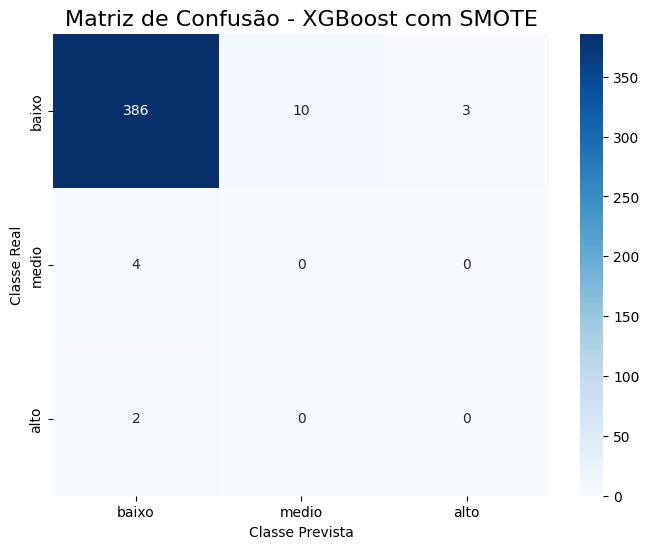

In [27]:
# Fazemos previsões no conjunto de teste ORIGINAL (não aumentado).
print("Fazendo previsões no conjunto de teste...")
y_pred = model.predict(X_test_scaled)

print(f"\nAcurácia do Modelo XGBoost: {accuracy_score(y_test, y_pred):.2%}\n")
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=mapeamento_risco.keys()))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=mapeamento_risco.keys(), yticklabels=mapeamento_risco.keys())
plt.title('Matriz de Confusão - XGBoost com SMOTE', fontsize=16)
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

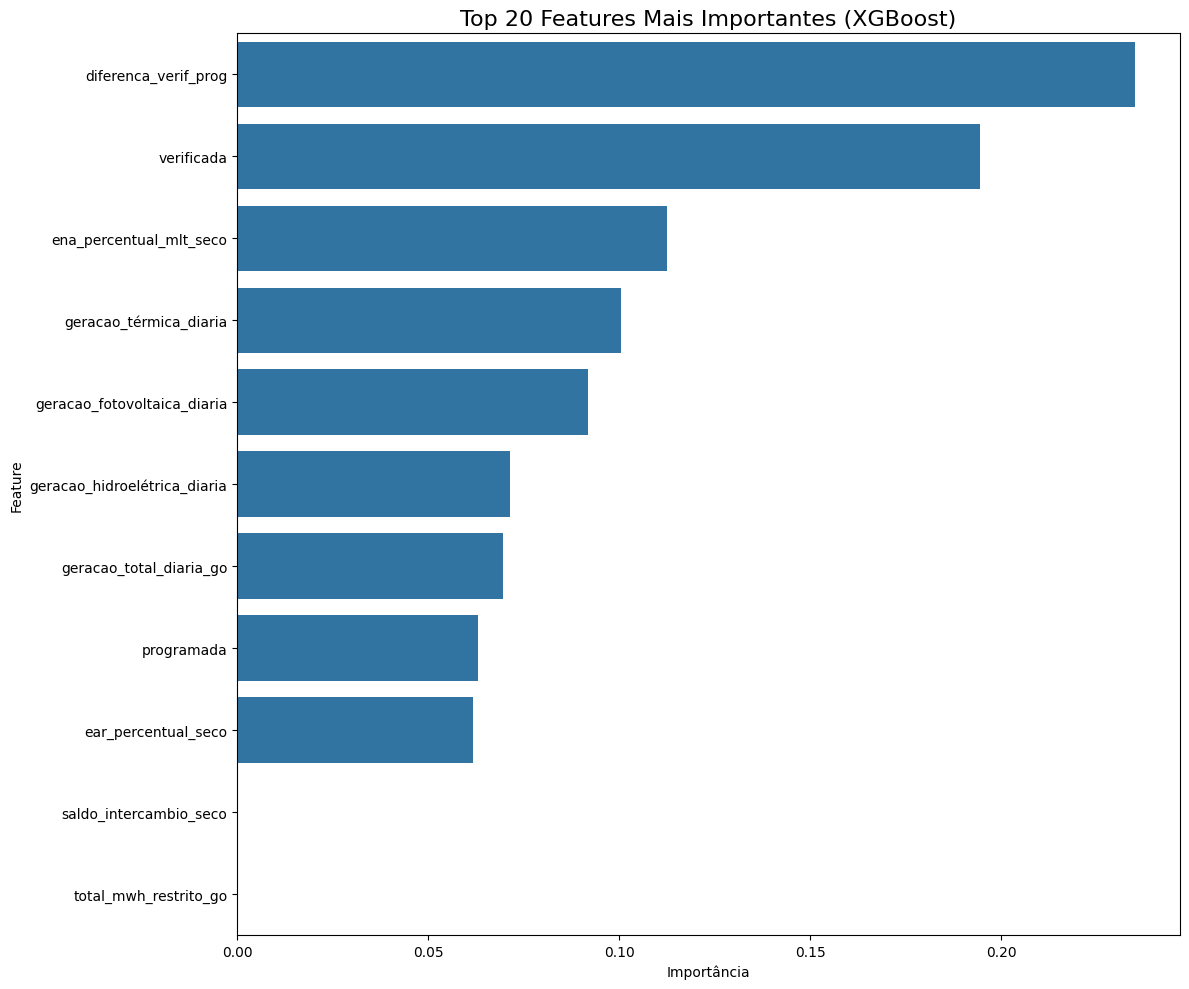

In [28]:
# O XGBoost nos diz quais features foram mais importantes para a decisão do modelo.
importances = model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20)) # Mostra as 20 mais importantes
plt.title('Top 20 Features Mais Importantes (XGBoost)', fontsize=16)
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()